In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from skbio.tree import TreeNode
from itertools import combinations
from scipy.stats import mannwhitneyu
from skbio.stats.distance import mantel
from glob import glob
from os.path import join, basename
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib_venn import venn2
from matplotlib_venn import venn3 as venn_3
#import venn

from ggmap.snippets import *
from ggmap.analyses import *
from ggmap.correlations import *
from ggmap.workflow import *
import calour as ca
ca.set_log_level(40)
import io

import requests
import json
import fetch
from ggmap.tree import *
from ggmap.utils import *
from ggmap.readwrite import *

from scipy.spatial import distance
from scipy.cluster import hierarchy

ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap
Reading settings file '/home/jansses/.ggmaprc'
ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap
Reading settings file '/home/jansses/.ggmaprc'
/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/docrep-0.2.5-py3.6.egg/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))
/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/docrep-0.2.5-py3.6.egg/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))
/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/docrep-0.2.5-py3.6.egg/docrep/__ini

In [2]:
x = pd.read_excel('Incoming/200107__Data_19-0037.xlsx', sheet_name="01.AllData").rename(columns={'Sample.label.on.tube': 'sample_name'})
meta = x[["MS.Label", "sample_name", "Species", "Tissue.type.(origin)", "Condition.1.(treatment)", "Condition.2.(Time)", "Condition.3", "Biological.replicate", "Harvested.culture.volume.[ml]", "Cell.density.[X*106/ml]", "resuspension.[µl]", "GC-MS", "GroupVar", "Normalization", "Normalized_by", "Multiplication_factor", "Acq.Method.File", "Data.File", "Sample.Type", "Position", "Inj.Vol", "Instrument", "SpeedVacVol", "Sample.Comment", "Sample.Approved"]].groupby('sample_name').first()
meta.columns = list(map(lambda x: x.replace('.', '_').replace('(', '_').replace(')', '_').replace('[', '_').replace(']', '_').replace('*', '_').replace('/', '_').replace('-', '_').replace('µ', 'u'), meta.columns))
for field in ['Condition_1__treatment_', 'Condition_3']:
    meta[field] = meta[field].apply(lambda x: x[1:] if x.startswith('_') else x)

data = x[['sample_name', "Compound", "ISTD", "Resp", "ISTD.Resp", "Resp.Ratio", "UserAnno.Peak", "MI.Peak", "MZ", "MZ.Ex.Left", "MZ.Ex.Right", "MZ.Ex.Units", "RT.Compound", "RT.Peak", "MS.Replicates", "data.source", "ISTD.Resp.Ratio", "Acq.Method.Condensed", "MS.project", "Report.Name", "data.dir", "relativeResponse", "IQR_1.5_outlier"]].set_index(['sample_name', 'Compound'])

counts = pd.pivot_table(data=data, columns='sample_name', index="Compound", values="relativeResponse").fillna(0)

In [3]:
res_alpha = alpha_diversity(counts, metrics=['shannon'], dry=False, wait=True, rarefaction_depth=None)
res_beta= beta_diversity(counts, metrics=['bray_curtis', 'jaccard'], dry=False, wait=False)
if res_beta['results'] is not None:
    res_emperor = emperor(meta, res_beta['results'], fp_results="./Emperor/", dry=False)

Using existing results from '.anacache/7831d53163866370681253749ab8e1bc.adiv'. 
Using existing results from '.anacache/88944ad280cc354549d767e70e016bf9.bdiv'. 
Using existing results from '.anacache/f59aa30dec7623b8765da2605364bba2.emperor'. 


In [8]:
res_sigtest = compare_categories(res_beta['results']['bray_curtis'], meta, dry=False, wait=False)

Found 1 temporary working directories, but non of them have finished. If no job is currently running, you might want to delete these directories and restart:
  /home/jansses/TMP/ana_cmpcat_408kpea4


In [9]:
res_corr = correlation_diversity_metacolumns(meta.applymap(lambda x: str(x)), list(meta.columns), res_alpha['results'], res_beta['results'], dry=False, wait=False)
cols_significant = [k for k,v in res_corr['results'].groupby('column')['p-value'].min().sort_values().iteritems() if v < 0.05 if '%28' not in k]
cols_significant

found matching working dir "/home/jansses/TMP/ana_corr-divmeta__s9y0s_x"
 Was removed.


['Acq_Method_File',
 'Condition_1__treatment_',
 'Condition_2__Time_',
 'Condition_3',
 'GC_MS',
 'GroupVar',
 'Harvested_culture_volume__ml_',
 'SpeedVacVol',
 'Normalization']

/home/jansses/miniconda3/envs/notebookServer/lib/python3.6/site-packages/scipy/stats/stats.py:2933: RuntimeWarning: divide by zero encountered in double_scalars
  f = msb / msw
/home/jansses/miniconda3/envs/notebookServer/src/ggmap/ggmap/correlations.py:241: RuntimeWarning: invalid value encountered in double_scalars
  r_ = (f_ / (f_*df_n + df_d))


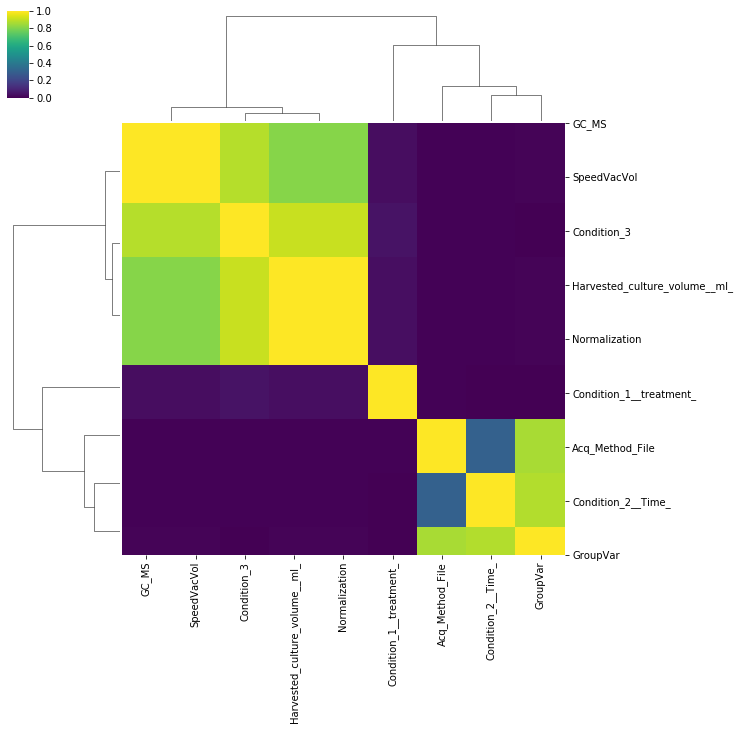

In [10]:
fields_categorials = ['Acq_Method_File', 'GroupVar', 'Condition_2__Time_']
fields_intervals = ['Normalization', 'Harvested_culture_volume__ml_', 'Condition_3', 'Condition_1__treatment_']
fields_ordinals = {'SpeedVacVol': [30, 50], 'GC_MS': [30, 50]}
res_corr_meta = correlate_metadata(meta.loc[:, cols_significant], fields_categorials, fields_ordinals, fields_intervals)

In [11]:
# 100% correlating metadata
cols_significant = [c for c in cols_significant if c not in ['GC_MS', 'Normalization']]

Using existing results from '.anacache/6b074b8f0eed48f76e033082f1ec49b8.fRDAalpha'. 
No significant findings.
found matching working dir "/home/jansses/TMP/ana_fRDAbeta_duz49ed0"
 Was removed.
Found 1 temporary working directories, but non of them have finished. If no job is currently running, you might want to delete these directories and restart:
  /home/jansses/TMP/ana_fRDAbeta_hbboqrt6


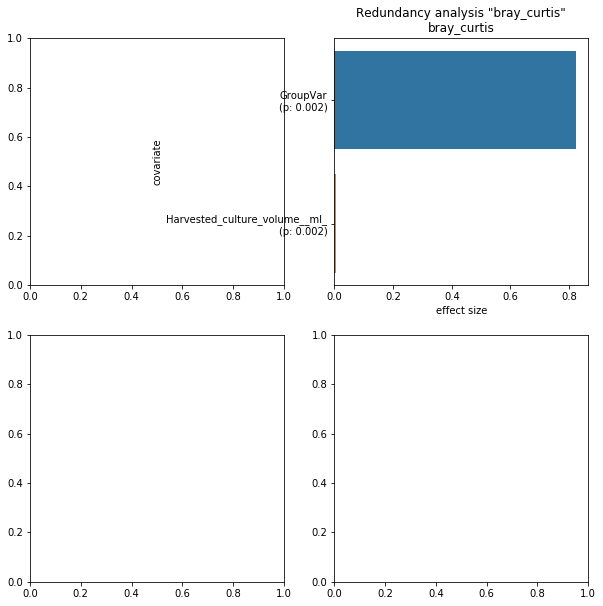

In [19]:
max_rows = max(len(res_alpha['results'].keys()), len(res_beta['results'].keys()))
fig, axes = plt.subplots(max_rows, 2, figsize=(5*2, 5*max_rows))
for i, metric in enumerate(res_alpha['results'].keys()):
    redundancy_analysis_alpha(meta, res_alpha['results'][metric],
                              categorials=[f for f in fields_categorials if f in cols_significant], 
                              ordinals={k: v for k,v in fields_ordinals.items() if k in cols_significant},
                              intervals=[f for f in fields_intervals if f in cols_significant],
                              dates={},
                              ax=axes[i][0], title=metric,
                              dry=False, wait=False)
for i, metric in enumerate(res_beta['results'].keys()):
    redundancy_analysis_beta(meta, res_beta['results'][metric], metric,
                             categorials=[f for f in fields_categorials if f in cols_significant], 
                             ordinals={k: v for k,v in fields_ordinals.items() if k in cols_significant},
                             intervals=[f for f in fields_intervals if f in cols_significant],
                             dates={},
                             ax=axes[i][1], title=metric,
                             dry=True, wait=False)

Using existing results from '.anacache/879cbffb3b90bae577c765baf955eff5.fRDAalpha'. 
Using existing results from '.anacache/b06d997bfe1893586430522ddc141a27.fRDAbeta'. 
No significant findings.
Using existing results from '.anacache/ec65f1d3a93742a6f1483e4de6bc3cb3.fRDAbeta'. 
No significant findings.


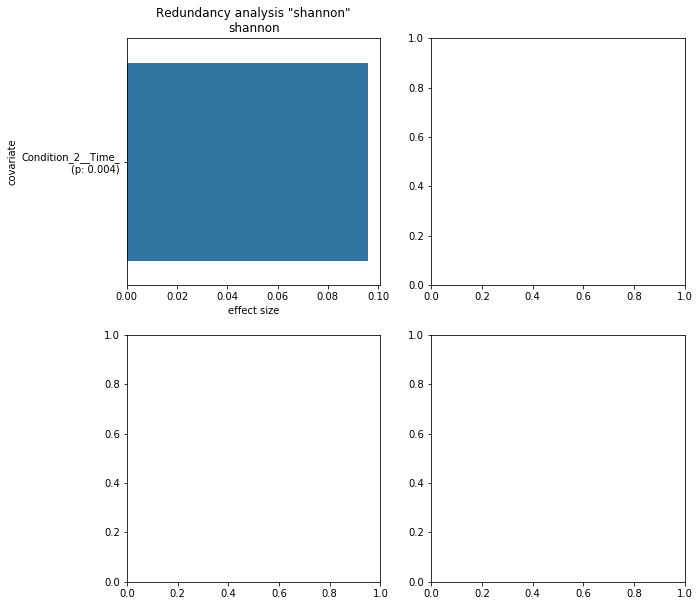

In [39]:
max_rows = max(len(res_alpha['results'].keys()), len(res_beta['results'].keys()))
fig, axes = plt.subplots(max_rows, 2, figsize=(5*2, 5*max_rows))
for i, metric in enumerate(res_alpha['results'].keys()):
    redundancy_analysis_alpha(meta, res_alpha['results'][metric],
                              categorials=['Condition_1__treatment_', 'Condition_2__Time_'], 
                              ordinals={},
                              intervals=[],#['Condition_3'],
                              dates={},
                              ax=axes[i][0], title=metric,
                              dry=False, wait=False)
for i, metric in enumerate(res_beta['results'].keys()):
    redundancy_analysis_beta(meta, res_beta['results'][metric], metric,
                             categorials=['Condition_1__treatment_', 'Condition_2__Time_'], 
                             ordinals={},
                             intervals=[],#['Condition_3'],
                             dates={},
                             ax=axes[i][1], title=metric,
                             dry=False, wait=False)

In [23]:
!rm -rf /home/jansses/TMP/ana_fRDAbeta_pzr_66_w

In [33]:
meta['Condition_3'].value_counts()

01     20
04     20
02     20
32     20
16     20
0.5    20
08     20
0       4
Name: Condition_3, dtype: int64

In [40]:
counts.shape

(48, 144)

In [48]:
x = pd.pivot_table(data=data, columns='sample_name', index="Compound", values="relativeResponse")
pd.isnull(x).sum(axis=1)

Compound
5-oxoproline_UK_11.18      0
Asparagine                 0
Aspartate                  0
Citrate+Isocitrate         0
DMPA                       0
Fumarate                   0
Gaba                       0
Glucose                    0
Glutamate                  0
Glutamine_UK_13.48         0
Glycerate                  0
Glycerol                   0
Glycerol-P_UK_13.45        0
Glycine                    0
Isoleucine                 0
Leucine                    0
Lysine                     0
Malate                     0
Maltose                    0
Methionine               104
Myoinositol                0
Ornithine                  0
Phenylalanine              0
Proline                    0
Putrescine                 0
Pyruvate                   0
Serine                     0
Succinate                  0
Threonate_UK_11.60         0
Threonine                  0
Tyrosine                   0
UK_17.84_Glc-P             0
UK_19.45_273               0
UK_9.298                   0
UK_9.